# Create Figures for Group AGF Paper

For each group, we should have 4 figures that make up a panel. We can organize these figures in Adobe Illustrator for the final figures.
- Loss plot with clear drops
- Model output power over epoch
- Weights over epoch (ideally one weight per irreps, but for MNIST just choose ~5.)
- Output prediction vs target over epoch

Action Plan:
- Load Model
- recreate power and loss figures

Weights figure
- go through weights and label them with their predomonant frequency
- Choose 1 weight per frequency, and plot these over time. In AI outline these weights with the same color as their power
- in the loss plot, try to make the color of the line (starting at the drop) match the color of the power and the irreps

Output figure
- detect jumps in power
- right after each jump, save epoch value for label
- at that epoch, plot Y[i] and model[X[i]] output.

In [1]:
import numpy as np
import random
import torch
import os
import torch.nn as nn
import torch.optim as optim
import shutil
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
import setcwd
setcwd.main()

import importlib
import pickle

import group_agf.binary_action_learning.models as models
import group_agf.binary_action_learning.datasets as datasets
import group_agf.binary_action_learning.power as power
import group_agf.binary_action_learning.plot as plot

from escnn.group import *

Git root path:  /home/adele/group-agf

Working directory:  /home/adele/group-agf/gagf
Directory added to path:  /home/adele/group-agf
Directory added to path:  /home/adele/group-agf/gagf/group_learning
Directory added to path:  /home/adele/group-agf/gagf/group_learning/saved_datasets
Directory added to path:  /home/adele/group-agf/gagf/notebooks
Directory added to path:  /home/adele/group-agf/gagf/notebooks/saved_models
Directory added to path:  /tmp/adele/


In [2]:
# parameters
config = {
    "model_save_dir": "/tmp/adele/",
    "dataset_fraction": 0.3,  # fraction of the total dataset to train on
    "group_name": 'dihedral',  # 'dihedral', 'znz_znz', 'octahedral'
    "mnist_digit": 4,
    "group_n": 4,  # n in Dn [3, 4, 5]
    "image_length": 10,  # length of one side of the square image patch
    # Learning Parameters
    "seed": 10,
    "init_scale": 1e-2,
    "lr": 0.001,
    "mom": 0.9,
    # Training parameters
    "epochs": 5000,
    "verbose_interval": 100,
    "batch_size": 128,
    "frequencies_to_learn": 3,
    "run_start_time": "10-31_14-42-46",
}

config["group"] = DihedralGroup(config["group_n"])
config["group_size"] = config["group"].order()

print(f"Group name: {config['group_name']}, group size: {config['group_size']}")

Group name: dihedral, group size: 8


In [3]:
from pyexpat import model


model_save_path = models.get_model_save_path(config)
print(model_save_path)
# model_save_path = '/tmp/adele/model_group_namedihedral_group_size8_frac0.3_init0.01_lr0.01_mom0.9_bs128_epochs5000_seed10_run_start10-31_14-25-32.pkl'
# print(model_save_path)

# Load training history and model parameters from the specified path
with open(model_save_path, 'rb') as f:
    training_history = pickle.load(f)

loss_history = training_history["loss_history"]
accuracy_history = training_history["accuracy_history"]
param_history = training_history["param_history"]

/tmp/adele/model_group_namedihedral_group_size8_init0.01_lr0.001_mom0.9_bs128_epochs5000_seed10_run_start10-31_14-42-46.pkl


In [4]:
X, Y, template = datasets.load_dataset(config)
template_power = power.GroupPower(template, config['group'])
X, Y, device = datasets.move_dataset_to_device_and_flatten(X, Y, device=None)

Computing inverse FT at element: (+, 0[2pi/4])
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Irrep (2, 2)
FT (2, 2)
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Computing inverse FT at element: (+, 1[2pi/4])
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Irrep (2, 2)
FT (2, 2)
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Computing inverse FT at element: (+, 2[2pi/4])
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Irrep (2, 2)
FT (2, 2)
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Computing inverse FT at element: (+, 3[2pi/4])
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Irrep (2, 2)
FT (2, 2)
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Computing inverse FT at element: (-, 0[2pi/4])
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Irrep (2, 2)
FT (2, 2)
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Computing inverse FT at element: (-, 1[2pi/4])
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Irrep (2, 2)
FT (2, 2)
Irrep (1, 1)
FT (1, 1)
Irrep (1, 1)
FT (1, 1)
Computing inverse FT at elem

In [5]:
# Create the model instance (matching the one that was trained)
model = models.TwoLayerNet(
    group_size=config['group_size'],
    hidden_size=None,  # uses default if not provided
    nonlinearity='square',  # adjust if needed according to training
    init_scale=config['init_scale'],
    output_scale=1.0
).to(device)

# Restore the model parameters from the last saved point in param_history
final_params = param_history[-1]
with torch.no_grad():
    model.U.copy_(final_params['U'])
    model.V.copy_(final_params['V'])
    model.W.copy_(final_params['W'])

Computing power at step 1 with output shape (64, 8)
Computing power at step 2 with output shape (64, 8)
Computing power at step 3 with output shape (64, 8)
Computing power at step 4 with output shape (64, 8)
Computing power at step 5 with output shape (64, 8)
Computing power at step 6 with output shape (64, 8)
Computing power at step 7 with output shape (64, 8)
Computing power at step 8 with output shape (64, 8)
Computing power at step 9 with output shape (64, 8)
Computing power at step 10 with output shape (64, 8)
Computing power at step 11 with output shape (64, 8)
Computing power at step 12 with output shape (64, 8)
Computing power at step 13 with output shape (64, 8)
Computing power at step 14 with output shape (64, 8)
Computing power at step 15 with output shape (64, 8)
Computing power at step 16 with output shape (64, 8)
Computing power at step 17 with output shape (64, 8)
Computing power at step 18 with output shape (64, 8)
Computing power at step 19 with output shape (64, 8)
Co

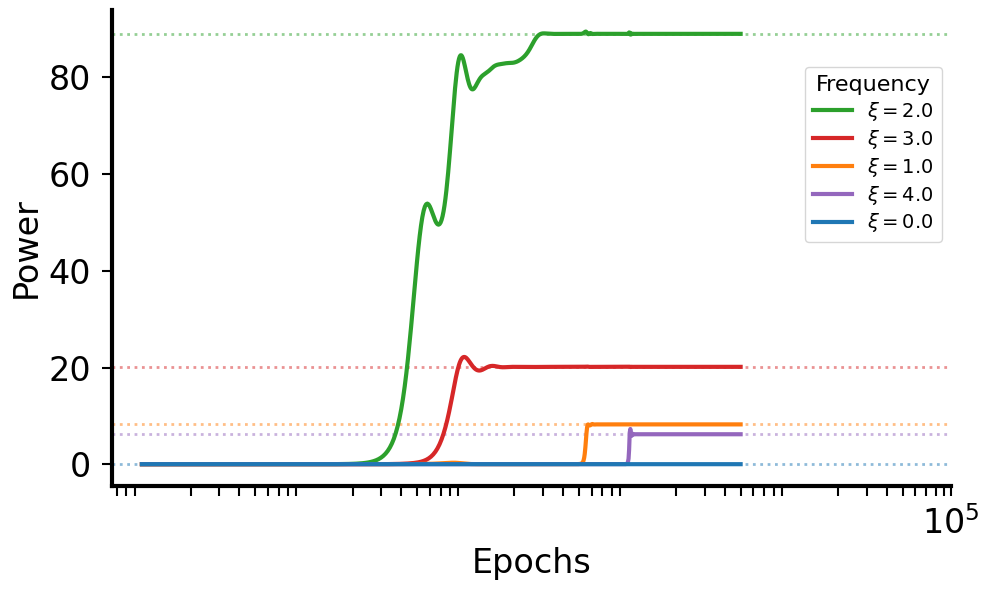

In [6]:
power_over_training_plot, freq_colors = plot.plot_training_power_over_time(
    template_power, 
    model, 
    device, 
    param_history, 
    X, 
    config['group_name'], 
    save_path=None, 
    show=False,
    return_freq_colors=True
)

Computing alpha values for template of shape: (8,)
[9.86076132e-32 8.23211396e+00 8.90238548e+01 2.01360777e+01
 6.19307773e+00]
Found  4 non-zero power coefficients.
Plotting 4 theoretical plateau lines.
Plotting alpha value 0: 15.448140529674484
Plotting alpha value 1: 4.320158676530766
Plotting alpha value 2: 1.8031489615435536
Plotting alpha value 3: 0.7741347159909615
Freq colors: ['C2', 'C3', 'C1', 'C4', 'C0'], number of alpha intervals: 3
Color for alpha value 0 (alpha=15.448140529674484): C2, number of points: 77
Color for alpha value 1 (alpha=4.320158676530766): C3, number of points: 179
Color for alpha value 2 (alpha=1.8031489615435536): C1, number of points: 306
Color for alpha values < 0.7741347159909615: C4, number of points: 4438


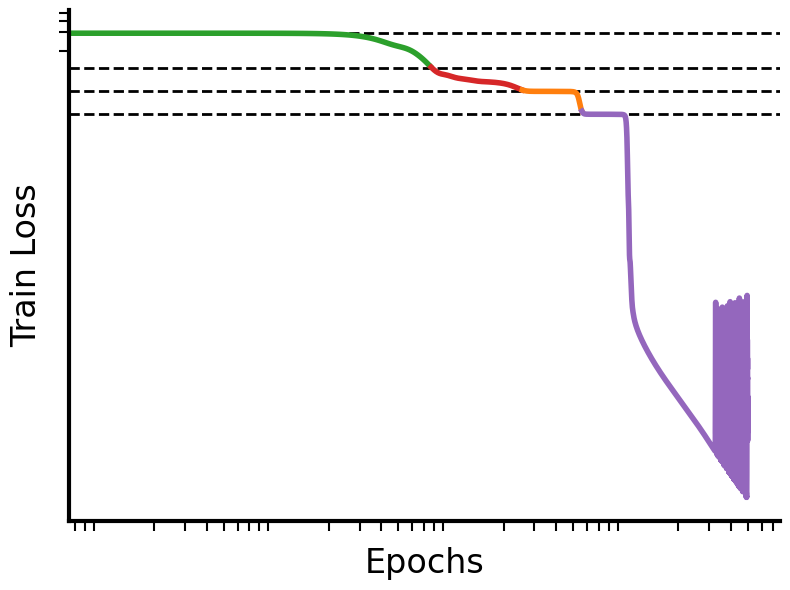

In [7]:
loss_plot = plot.plot_loss_curve(loss_history, template_power, show=False, freq_colors=freq_colors)


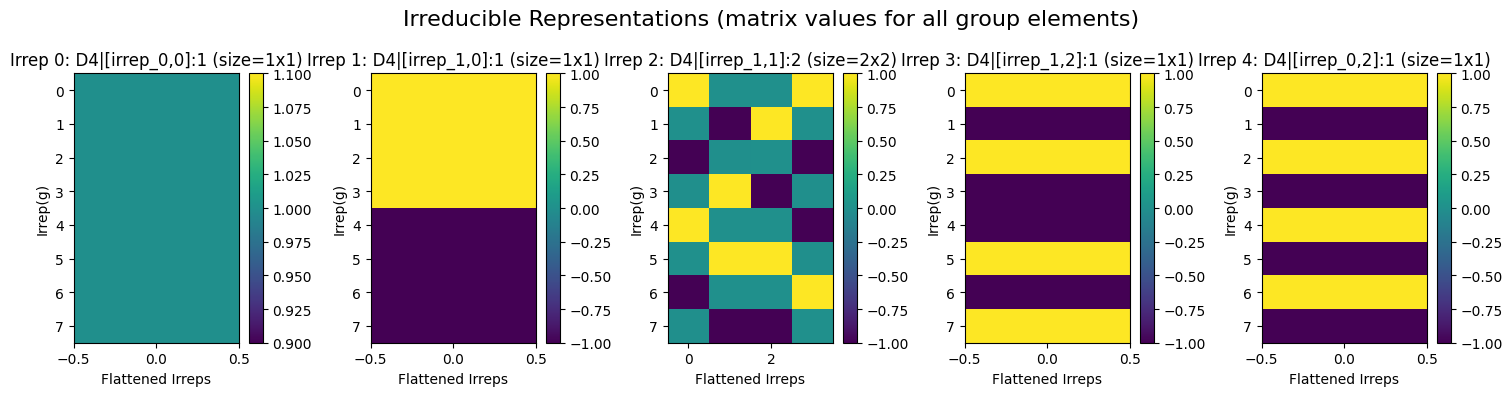

In [ ]:
irreps_plot = plot.plot_irreps(config['group'], config['group_name'], show=False)


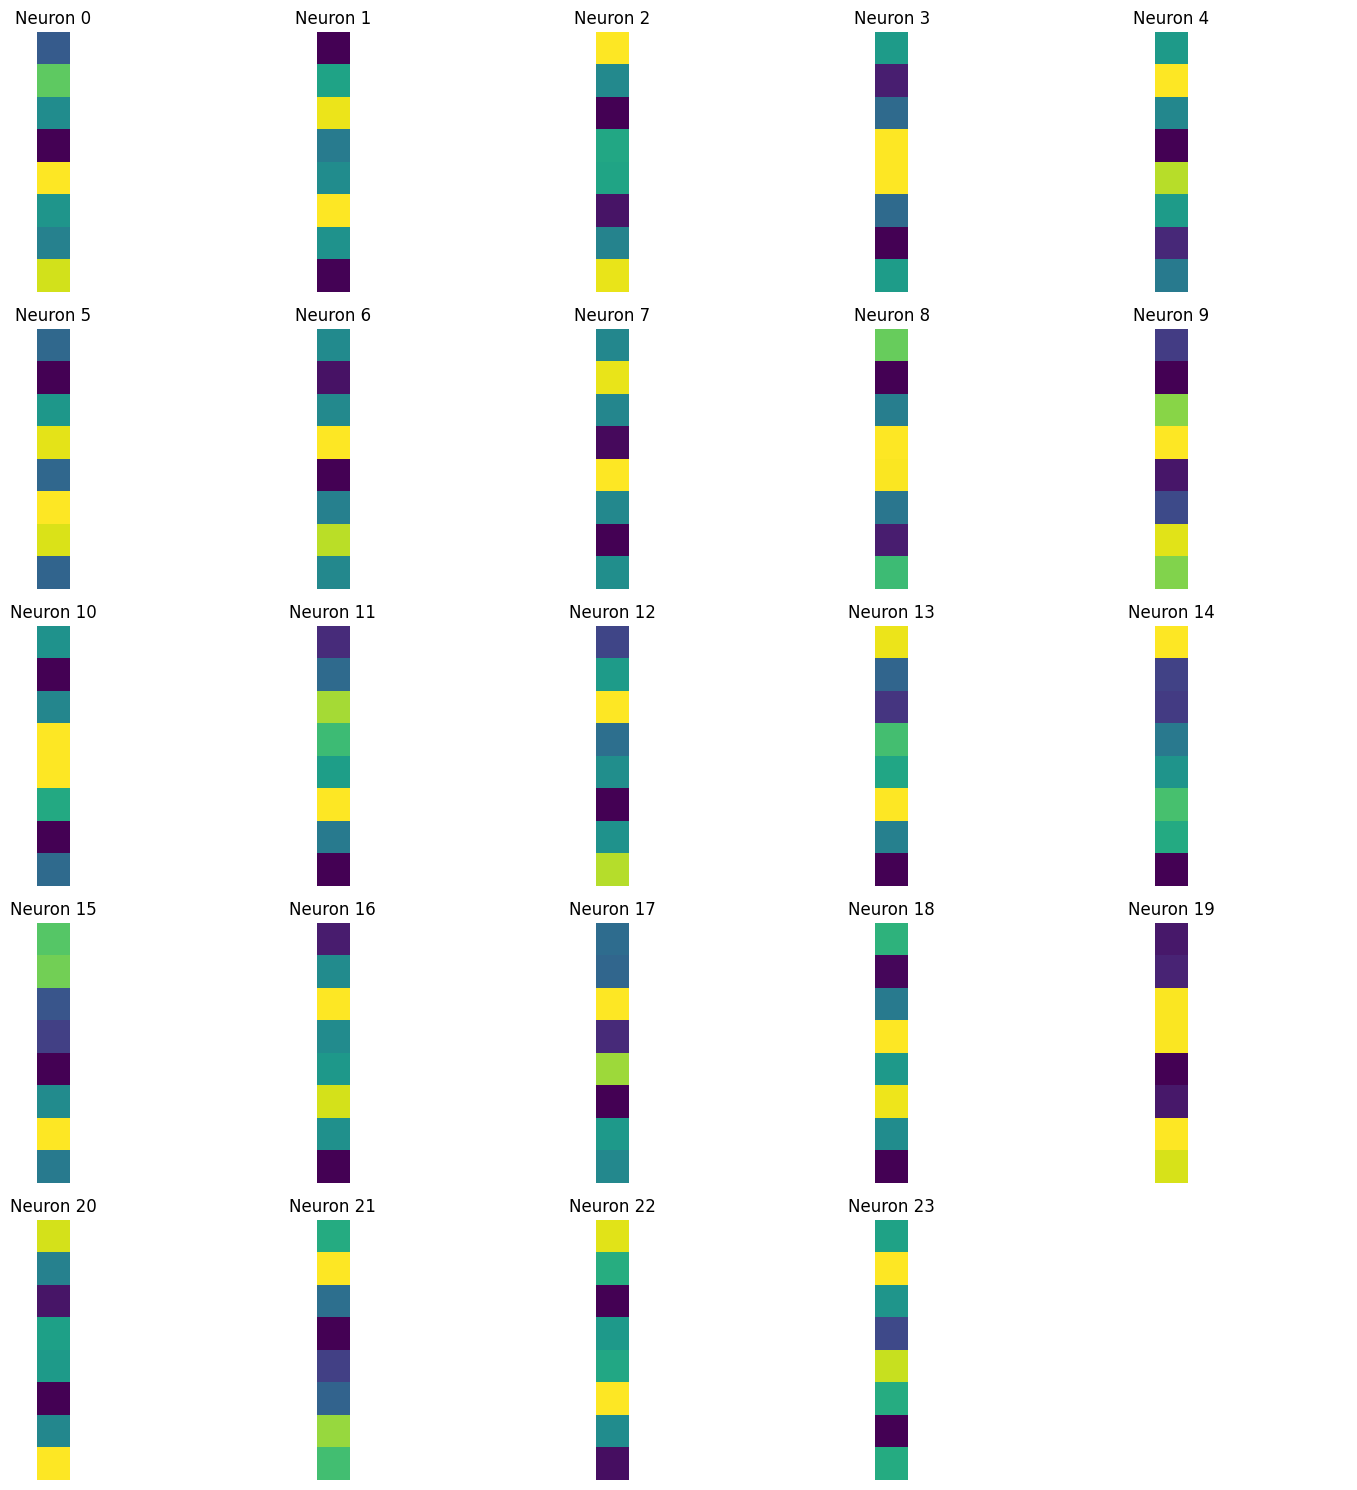

In [9]:
neuron_indices = list(range(config['group_size'] * config['frequencies_to_learn']))
neuron_weights_plot = plot.plot_neuron_weights(
    config['group_name'],
    config['group'],
    model,
    config['group_size'],
    neuron_indices=neuron_indices,
    show=True
)

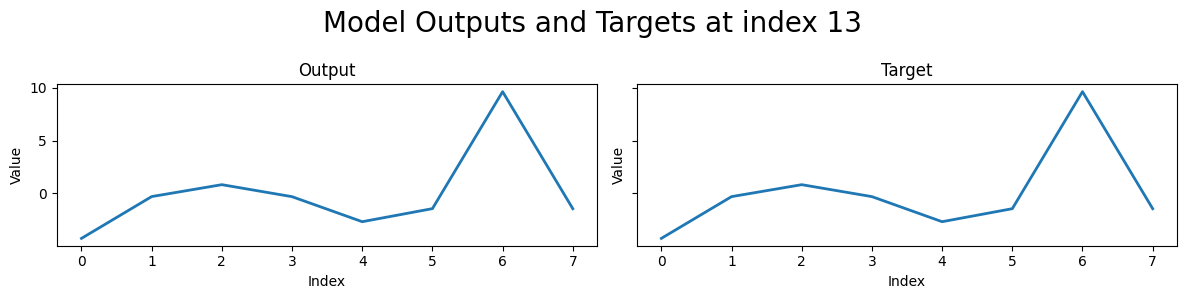

In [10]:
model_predictions_plot = plot.plot_model_outputs(config['group_name'], config['group_size'], model, X, Y, idx=13, step=1, show=True)  
